In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from pathlib import Path
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

2024-03-17 19:40:28.580041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
# Define the stock symbols for the financial institutions we're interested in
stock_symbols = ['AAPL', 'KO', 'NKE', 'EA']
# Define the start and end dates for our data
start_date = '2021-01-01'
end_date = '2024-03-16'

# Function to download stock data
def download_stock_data(symbols):
    data = {}
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start=start_date, end=end_date)
    return data

# Download stock data
stocks_data = download_stock_data(stock_symbols)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [46]:
# Display the first few rows of Apple's stock data
print(stocks_data['KO'].tail())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2024-03-11  59.779999  60.290001  59.580002  60.240002  59.761982  14114300
2024-03-12  60.320000  60.750000  60.209999  60.500000  60.019920  12684600
2024-03-13  60.880001  61.209999  60.799999  61.119999  60.634998  13909500
2024-03-14  60.580002  60.799999  60.400002  60.500000  60.500000  13996600
2024-03-15  60.020000  60.450001  59.639999  59.880001  59.880001  36848900


In [47]:
# Calculate technical indicators and OHLC ratios for stock
def calculate_features(data):
    # Moving Average
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    # Exponential Moving Average
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # OHLC Ratios
    data['HLC_Ratio'] = (data['High'] - data['Low']) / data['Close']
    data['OC_Ratio'] = (data['Open'] - data['Close']) / data['Close']
    
    # Drop NaN values generated by moving averages and RSI
    data.dropna(inplace=True)
    return data

# Apply feature engineering to stocks
for symbol in stocks_data:
    stocks_data[symbol] = calculate_features(stocks_data[symbol])

In [48]:
df2 = stocks_data['KO']
df2

,Open,High,Low,Close,Adj Close,Volume,MA_10,EMA_10,RSI,HLC_Ratio,OC_Ratio
Date,,,,,,,,,,,
2021-01-22,48.810001,48.939999,48.490002,48.490002,43.909611,15400300,49.411,49.404472,21.495370,0.009280,0.006599
2021-01-25,48.419998,48.840000,48.240002,48.779999,44.172218,16604200,49.181,49.290932,24.421605,0.012300,-0.007380
2021-01-26,48.910000,49.400002,48.610001,49.290001,44.634048,12922600,49.090,49.290762,31.258127,0.016028,-0.007709
2021-01-27,48.889999,49.320000,48.230000,48.529999,43.945824,21242400,48.932,49.152442,35.389141,0.022460,0.007418
2021-01-28,48.689999,49.500000,48.610001,49.150002,44.507271,17498900,48.831,49.151998,44.104830,0.018108,-0.009359
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,59.779999,60.290001,59.580002,60.240002,59.761982,14114300,59.837,59.871328,44.221133,0.011786,-0.007636
2024-03-12,60.320000,60.750000,60.209999,60.500000,60.019920,12684600,59.853,59.985632,40.000000,0.008926,-0.002975
2024-03-13,60.880001,61.209999,60.799999,61.119999,60.634998,13909500,59.925,60.191881,49.645360,0.006708,-0.003927


In [49]:
df2 = df2['Close']

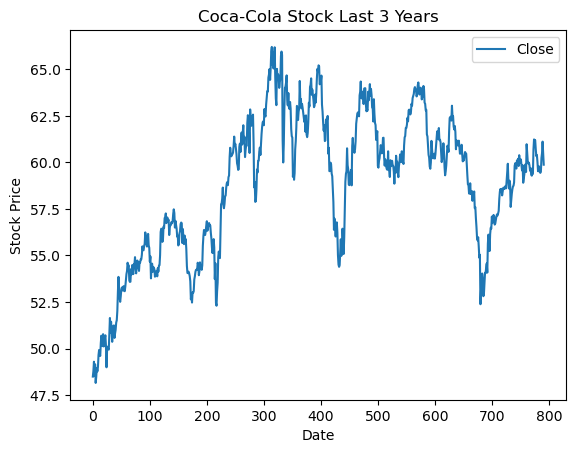

In [78]:
#Make plot
df2.plot(y='Close', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Coca-Cola Stock Last 3 Years')

# Show the plot
plt.show()

In [51]:
# Scale the data
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(792, 1)

In [52]:
# Separate data points, not currently using valid_data but could use if we pulled more of the dataset.
train_data=df2[0:793]
valid_data=df2[793:,]

# Create train and testing sizes
train_size = int(len(df2)*0.80)
test_size = len(df2) - train_size
train_data, test_data = df2[:train_size], df2[train_size:]

In [53]:
# Using def to create dataset lists for training
def create_dataset(data, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(data)-time_step-1):
                   a = data[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(data[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [54]:
# Set variables to start training and testing data
time_step = 100
X_train, Y_train =  create_dataset(train_data, time_step)
X_test, Y_test =  create_dataset(test_data, time_step)

In [55]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(532, 100)
[[0.01882615 0.03488357 0.0631229  ... 0.44352156 0.40974522 0.40199332]
 [0.03488357 0.0631229  0.02104083 ... 0.40974522 0.40199332 0.36101869]
 [0.0631229  0.02104083 0.05537099 ... 0.40199332 0.36101869 0.37652271]
 ...
 [0.59302329 0.64064237 0.62513835 ... 0.78848282 0.79125133 0.79235878]
 [0.64064237 0.62513835 0.67607977 ... 0.79125133 0.79235878 0.78073092]
 [0.62513835 0.67607977 0.6566998  ... 0.79235878 0.78073092 0.82502767]]
(58, 100)
(58,)


In [56]:
# Create the model
stock_model = Sequential()
stock_model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
stock_model.add(LSTM(50,return_sequences = True))
stock_model.add(LSTM(50))
stock_model.add(Dense(1))
stock_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [57]:
#Fit the model
stock_model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 20,batch_size = 32,verbose = 1)

Epoch 1/20
17/17 [==============================] - 6s 133ms/step - loss: 0.1137 - val_loss: 0.0155
Epoch 2/20
17/17 [==============================] - 1s 75ms/step - loss: 0.0164 - val_loss: 0.0058
Epoch 3/20
17/17 [==============================] - 1s 81ms/step - loss: 0.0114 - val_loss: 0.0017
Epoch 4/20
17/17 [==============================] - 1s 79ms/step - loss: 0.0099 - val_loss: 0.0019
Epoch 5/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0100 - val_loss: 0.0014
Epoch 6/20
17/17 [==============================] - 1s 81ms/step - loss: 0.0094 - val_loss: 0.0017
Epoch 7/20
17/17 [==============================] - 1s 80ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 8/20
17/17 [==============================] - 2s 86ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 9/20
17/17 [==============================] - 1s 87ms/step - loss: 0.0076 - val_loss: 0.0015
Epoch 10/20
17/17 [==============================] - 2s 93ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 11

In [58]:
#Use model to predict
train_predict = stock_model.predict(X_train)
test_predict = stock_model.predict(X_test)

2/2 [==============================] - 0s 154ms/step


In [59]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [60]:
model_predictions = stock_model.predict(X_train)
true_labels = Y_train

17/17 [==============================] - 0s 27ms/step


In [61]:
#Pull metrics to test accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(true_labels, model_predictions)
print("Mean Absolute Error (MAE):", mae)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, model_predictions)
print("Mean Squared Error (MSE):", mse)

# Compute R^2 Score
r2 = r2_score(true_labels, model_predictions)
print("R^2 Score:", r2)

Mean Absolute Error (MAE): 0.0542939042859253
Mean Squared Error (MSE): 0.005061640040869908
R^2 Score: 0.8503000297374157


In [62]:
# Create variables to plot
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

In [63]:
trainPredictPlot = pd.DataFrame(trainPredictPlot)
trainPredictPlot[600:]

,0
600,60.027794
601,60.089832
602,60.174416
603,60.286537
604,60.432388
...,...
787,NaN
788,NaN
789,NaN
790,NaN


In [64]:
#Transform back to normal values
df2 = scaler.inverse_transform(df2)

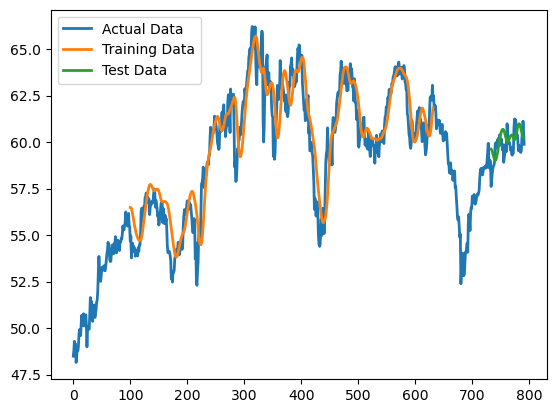

In [65]:
#Create overlapping plots of data, testing data, and training data
plt.plot(df2, label="Actual Data", linewidth=2)
plt.plot(trainPredictPlot, label="Training Data", linewidth=2)
plt.plot(testPredictPlot, label="Test Data", linewidth=2)

plt.legend()
plt.show()

In [66]:
# Number of future days to predict
future_days = 1
future_predictions = []
last_sequence = X_test[-1].reshape(1, -1)

for i in range(future_days):
    # Predict the next day's value with last sequence
    next_prediction = stock_model.predict(last_sequence)
    # Inverse transform to get the actual predicted value
    next_prediction = scaler.inverse_transform(next_prediction)
    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)
    # Update last_sequence for the next prediction
    last_sequence = next_prediction.reshape(1, -1)

1/1 [==============================] - 0s 33ms/step


In [67]:
future_predictions

[array([[60.232986]], dtype=float32)]

In [68]:
df2 = pd.DataFrame(df2)

In [69]:
df2[['Close']] = df2

In [70]:
df2 = df2[['Close']]
df2

,Close
0,48.490002
1,48.779999
2,49.290001
3,48.529999
4,49.150002
...,...
787,60.240002
788,60.500000
789,61.119999
790,60.500000


In [71]:
# Add prediction to dataframe for side-by-side comparison of day's closing price and next day's prediction
model_data=df2[:792]
predict_data=df2[791:]
predict_data['Predictions']=next_prediction
print(predict_data)
print(f'Predicted Closing Price for March 18th, 2024:{next_prediction}')
if next_prediction.item() > predict_data['Close'].item():
    print(f'Tomorrow morning, you should BUY')
else:
    print(f'Tomorrow morning, you should SELL')

         Close  Predictions
791  59.880001    60.232986
Predicted Closing Price for March 18th, 2024:[[60.232986]]
Tomorrow morning, you should BUY


/var/folders/by/st2c4w_96757fgwg7jsfc4480000gn/T/ipykernel_54293/1464025085.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



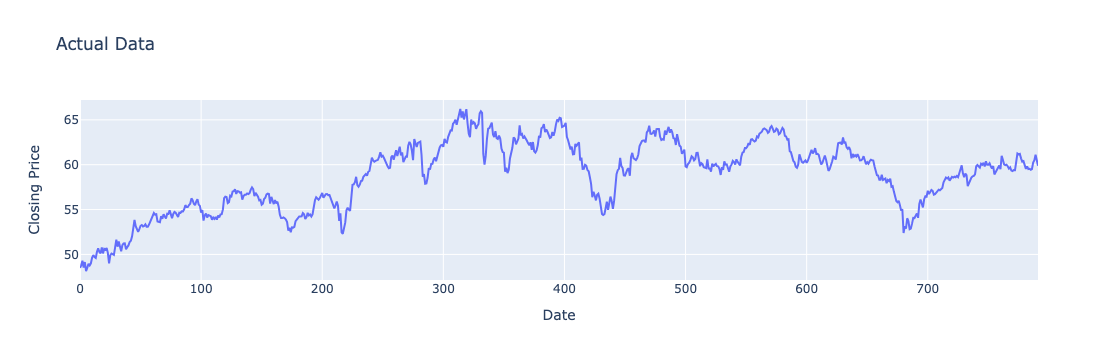

In [72]:
# Create traces
trace1 = go.Scatter(x=df2.index, y=df2['Close'], mode='lines', name='Actual Data', line=dict(width=2))

# Plot layout
layout = go.Layout(
    title='Actual Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure
fig = go.Figure(data=[trace1], layout=layout)

# Show plot
fig.show()

In [73]:
print("trainPredictPlot values:", trainPredictPlot)
print("testPredictPlot values:", testPredictPlot)

trainPredictPlot values:       0
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
..   ..
787 NaN
788 NaN
789 NaN
790 NaN
791 NaN

[792 rows x 1 columns]
testPredictPlot values: [[        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [    

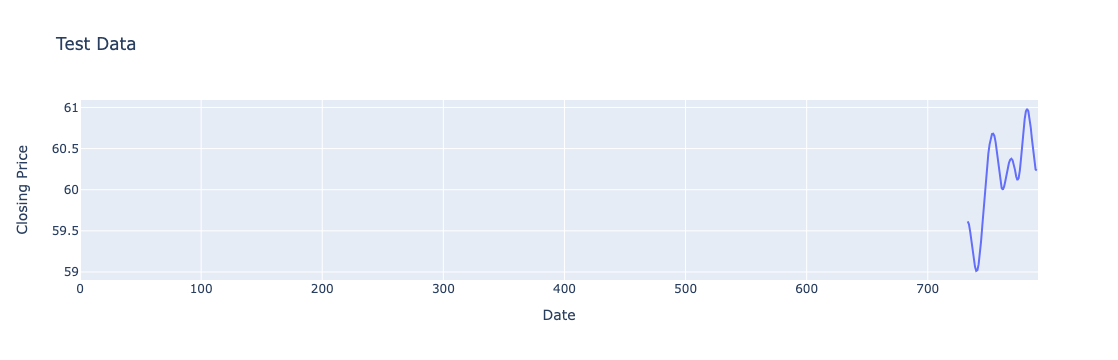

In [74]:
trace_test = go.Scatter(x=df2.index[len(df2) - len(testPredictPlot):], y=testPredictPlot.flatten(), mode='lines', name='Test Data', line=dict(width=2))

# Plot layout for test data
layout_test = go.Layout(
    title='Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for test data
fig_test = go.Figure(data=[trace_test], layout=layout_test)

# Show plot for test data
fig_test.show()

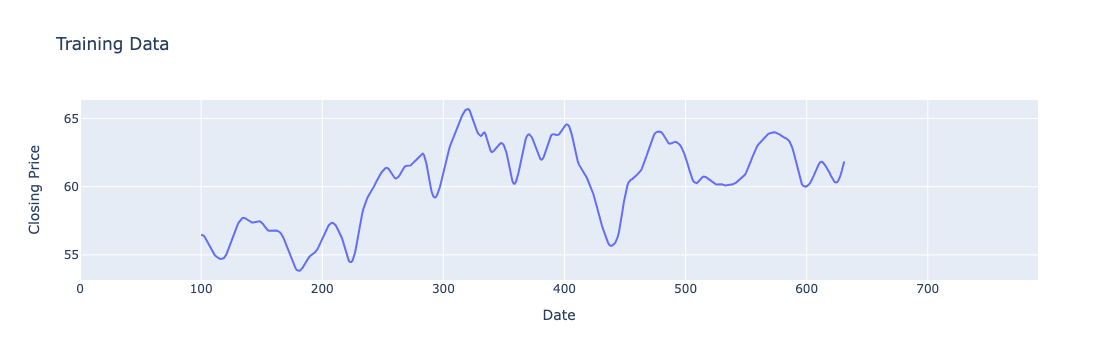

In [75]:
# Create trace for training data
trace_train = go.Scatter(x=df2.index[:len(trainPredictPlot)], y=trainPredictPlot.values.flatten(), mode='lines', name='Training Data', line=dict(width=2))

# Plot layout for training data
layout_train = go.Layout(
    title='Training Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for training data
fig_train = go.Figure(data=[trace_train], layout=layout_train)

# Show plot for training data
fig_train.show()

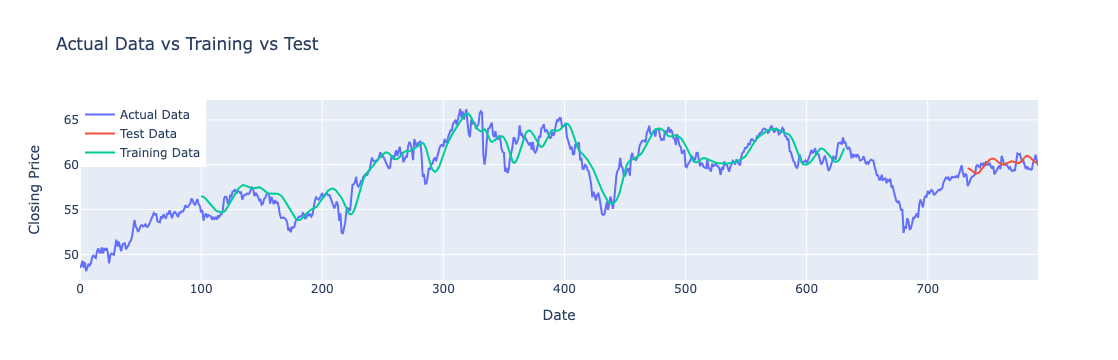

In [76]:
# Create traces for all three datasets
trace_actual = go.Scatter(x=df2.index, y=df2['Close'], mode='lines', name='Actual Data', line=dict(width=2))
trace_test = go.Scatter(x=df2.index[len(df2) - len(testPredictPlot):], y=testPredictPlot.flatten(), mode='lines', name='Test Data', line=dict(width=2))
trace_train = go.Scatter(x=df2.index[:len(trainPredictPlot)], y=trainPredictPlot.values.flatten(), mode='lines', name='Training Data', line=dict(width=2))

# Plot layout for all datasets
layout_all = go.Layout(
    title='Actual Data vs Training vs Test',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for all datasets
fig_all = go.Figure(data=[trace_actual, trace_test, trace_train], layout=layout_all)

# Show plot for all datasets
fig_all.show()